In [1]:
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

from pymutspec.draw import plot_mutspec12
from pymutspec.annotation import CodonAnnotation
from pymutspec.constants import possible_codons
from pymutspec.io import read_genbank_ref

from scipy.stats import chisquare, ks_2samp, pearsonr, spearmanr, uniform
from scipy.special import kl_div
from sklearn.metrics import mean_squared_error
import tqdm

from utils import (
    amino_acid_codes, alphabet, cdn_spectrum_to_matrix, 
    nuc_spectrum_to_matrix, collect_possible_changes,
    get_equilibrium_probabilities, plot_exp_heatmap,
    prepare_aa_subst, plot_aa_eq_freqs, prepare_exp_aa_subst
)

In [2]:
coda = CodonAnnotation(1)

## Load reference and calc amino acid freqs

In [3]:
from Bio import SeqIO
rec = next(SeqIO.parse("data/NC_045512.2.gb", "genbank"))

In [4]:
ref_df = pd.DataFrame([f.qualifiers for f in rec.features if f.type == "CDS"])
ref_df.drop(columns=["locus_tag", "ribosomal_slippage", "codon_start", 
                     "db_xref", 'gene_synonym'], inplace=True)
ref_df["gene"] = ref_df["gene"].apply(lambda x: x[0])
ref_df["product"] = ref_df["product"].apply(lambda x: x[0])
ref_df["protein_id"] = ref_df["protein_id"].apply(lambda x: x[0])
ref_df["translation"] = ref_df["translation"].apply(lambda x: x[0])
ref_df = ref_df[ref_df['product'] != 'ORF1a polyprotein']
ref_df.to_csv('./data/ref_proteins.csv', index=False)
ref_df

,gene,note,product,protein_id,translation
0,ORF1ab,[pp1ab; translated by -1 ribosomal frameshift],ORF1ab polyprotein,YP_009724389.1,MESLVPGFNEKTHVQLSLPVLQVRDVLVRGFGDSVEEVLSEARQHL...
2,S,[structural protein; spike protein],surface glycoprotein,YP_009724390.1,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...
3,ORF3a,NaN,ORF3a protein,YP_009724391.1,MDLFMRIFTIGTVTLKQGEIKDATPSDFVRATATIPIQASLPFGWL...
4,E,[ORF4; structural protein; E protein],envelope protein,YP_009724392.1,MYSFVSEETGTLIVNSVLLFLAFVVFLLVTLAILTALRLCAYCCNI...
5,M,[ORF5; structural protein],membrane glycoprotein,YP_009724393.1,MADSNGTITVEELKKLLEQWNLVIGFLFLTWICLLQFAYANRNRFL...
6,ORF6,NaN,ORF6 protein,YP_009724394.1,MFHLVDFQVTIAEILLIIMRTFKVSIWNLDYIINLIIKNLSKSLTE...
7,ORF7a,NaN,ORF7a protein,YP_009724395.1,MKIILFLALITLATCELYHYQECVRGTTVLLKEPCSSGTYEGNSPF...
8,ORF7b,NaN,ORF7b,YP_009725318.1,MIELSLIDFYLCFLAFLLFLVLIMLIIFWFSLELQDHNETCHA
9,ORF8,NaN,ORF8 protein,YP_009724396.1,MKFLVFLGIITTVAAFHQECSLQSCTQHQPYVVDDPCPIHFYSKWY...
10,N,[ORF9; structural protein],nucleocapsid phosphoprotein,YP_009724397.2,MSDNGPQNQRNAPRITFGGPSDSTGSNQNGERSGARSKQRRPQGLP...


In [5]:
aa_freqs_df = pd.DataFrame(ref_df.set_index('gene')['translation']\
                           .apply(Counter).to_dict()).T.fillna(0).astype(int)
aa_freqs_df.to_csv('./data/ref_aa_freqs.csv')
aa_freqs_df

,M,E,S,L,V,P,G,F,N,K,T,H,Q,R,D,A,C,Y,I,W
ORF1ab,168,340,456,668,598,274,412,349,384,434,527,145,239,244,389,487,226,335,343,78
S,14,48,99,108,97,58,82,77,88,61,97,17,62,42,62,79,40,54,76,12
ORF3a,4,11,22,30,25,12,14,14,8,11,24,8,9,6,13,13,7,17,21,6
E,1,2,8,14,13,2,1,5,5,2,4,0,0,3,1,4,3,4,3,0
M,4,7,15,35,12,5,14,11,11,7,13,5,4,14,6,19,4,9,20,7
ORF6,3,5,4,8,3,1,0,3,4,4,3,1,3,1,4,1,0,2,10,1
ORF7a,1,8,7,15,8,6,4,10,2,7,10,3,5,5,2,9,6,5,8,0
ORF7b,2,3,2,11,1,0,0,6,1,0,1,2,1,0,2,2,2,1,5,1
ORF8,1,6,9,10,12,7,5,8,2,5,5,4,6,4,7,5,7,7,10,1
N,7,12,37,27,8,28,43,13,22,31,32,4,35,29,24,37,0,11,14,5


In [6]:
aa_freqs_total_dct = aa_freqs_df.rename(columns=amino_acid_codes).sum(0).to_dict()
aa_freqs_total_dct

{'Met': 207,
 'Glu': 442,
 'Ser': 661,
 'Leu': 930,
 'Val': 781,
 'Pro': 394,
 'Gly': 576,
 'Phe': 500,
 'Asn': 532,
 'Lys': 562,
 'Thr': 718,
 'His': 189,
 'Gln': 365,
 'Arg': 350,
 'Asp': 511,
 'Ala': 658,
 'Cys': 296,
 'Tyr': 448,
 'Ile': 513,
 'Trp': 111}

## Load spectrum and calculate expected AA subst matrix and equilibrium

In [7]:
## read external clades spectra
# https://raw.githubusercontent.com/jbloomlab/SARS2-mut-spectrum/refs/heads/main/results/synonymous_mut_rates/rates_by_clade.csv

clades_spectra = pd.read_csv('data/rates_by_clade.csv')
clades_spectra['Mut'] = clades_spectra['mut_type'].str.replace('to', '>')
spectrum_20A = clades_spectra[clades_spectra['clade'] == '20A'].copy()
spectrum_20A['rate'] /= spectrum_20A['rate'].sum()
spectrum_20A

,clade,mut_type,count,total_count,fraction,parent_nt,parent_nt_frac,rate,Mut
0,20A,AtoC,286,17202,0.016626,A,0.289620,0.007791,A>C
1,20A,AtoG,1617,17202,0.094001,A,0.289620,0.044050,A>G
2,20A,AtoT,515,17202,0.029938,A,0.289620,0.014029,A>T
3,20A,CtoA,339,17202,0.019707,C,0.137040,0.019518,C>A
4,20A,CtoG,130,17202,0.007557,C,0.137040,0.007484,C>G
5,20A,CtoT,7113,17202,0.413500,C,0.137040,0.409514,C>T
6,20A,GtoA,837,17202,0.048657,G,0.064987,0.101614,G>A
7,20A,GtoC,137,17202,0.007964,G,0.064987,0.016632,G>C
8,20A,GtoT,2670,17202,0.155210,G,0.064987,0.324148,G>T
9,20A,TtoA,565,17202,0.032845,T,0.508360,0.008769,T>A


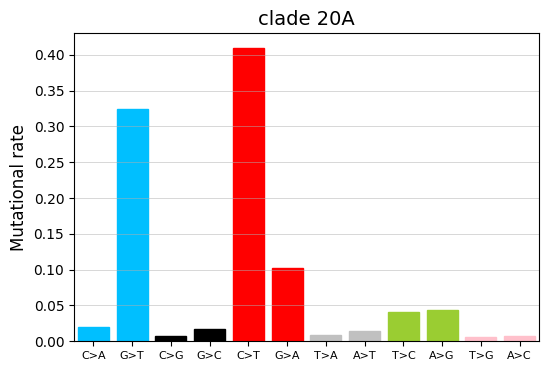

<Axes: title={'center': 'clade 20A'}, ylabel='Mutational rate'>

In [8]:
plot_mutspec12(spectrum_20A, 'rate', 'clade 20A', 
               ylabel='Mutational rate', 
            #    savepath='./figures/20A_spectrum.png'
)

In [9]:
df_changes = collect_possible_changes(gc=1)
clade_specific_spectrum = spectrum_20A.set_index('Mut').rate.to_dict()

# df_changes['rate'] = df_changes['sbs'].map(clade_specific_spectrum)
# df_changes['aa1'] = df_changes['aa1'].map(amino_acid_codes)
# df_changes['aa2'] = df_changes['aa2'].map(amino_acid_codes)
df_changes


,pic,cdn1,cdn2,aa1,aa2,is_syn,sbs
0,0,AAA,CAA,Lys,Gln,False,A>C
1,0,AAA,GAA,Lys,Glu,False,A>G
2,0,AAA,TAA,Lys,*,False,A>T
3,1,AAA,ACA,Lys,Thr,False,A>C
4,1,AAA,AGA,Lys,Arg,False,A>G
...,...,...,...,...,...,...,...
571,1,TTT,TCT,Phe,Ser,False,T>C
572,1,TTT,TGT,Phe,Cys,False,T>G
573,2,TTT,TTA,Phe,Leu,False,T>A
574,2,TTT,TTC,Phe,Phe,True,T>C


In [10]:
df_changes = collect_possible_changes(gc=1)
clade_specific_spectrum = spectrum_20A.set_index('Mut').rate.to_dict()

df_changes['rate'] = df_changes['sbs'].map(clade_specific_spectrum)

## Calculate expected AA substitutions matrix
exp_aa_subst = df_changes[(df_changes.aa1 != '*')&(df_changes.aa2 != '*')]\
    .groupby(['aa1', 'aa2'])['rate'].sum().reset_index()
exp_aa_subst.to_csv('data/exp_aa_subst.csv', float_format='%g', index=False)
exp_aa_subst_matrix = exp_aa_subst.pivot(index='aa1', columns='aa2', values='rate').fillna(0.)


## Calculate codon and AA equilibrium frequencies
cdn_sbs = df_changes.groupby(['cdn1', 'cdn2'])['rate'].sum()
M = cdn_spectrum_to_matrix(cdn_sbs)
eq_prob = get_equilibrium_probabilities(M).astype(float)

eq_freqs_cdn = pd.Series(dict(zip(possible_codons, eq_prob)))
eq_freqs_cdn.name = 'freq'
eq_freqs_cdn.index.name = 'cdn'
eq_freqs_cdn = eq_freqs_cdn.reset_index()
eq_freqs_cdn['aa'] = eq_freqs_cdn['cdn'].map(coda.translate_codon).map(amino_acid_codes)

eq_freqs_cdn.to_csv('./data/cdn_eq_freqs.csv', index=False, float_format='%g')
eq_freqs_cdn

/tmp/ipykernel_501044/934580521.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  eq_prob = get_equilibrium_probabilities(M).astype(float)


,cdn,freq,aa
0,AAA,0.004267,Lys
1,AAC,0.001897,Asn
2,AAG,0.000726,Lys
3,AAT,0.019418,Asn
4,ACA,0.001897,Thr
...,...,...,...
59,TGT,0.015035,Cys
60,TTA,0.088360,Leu
61,TTC,0.039289,Phe
62,TTG,0.015035,Leu


In [11]:
exp_aa_subst_matrix

aa2,Ala,Arg,Asn,Asp,Cys,Gln,Glu,Gly,His,Ile,Leu,Lys,Met,Phe,Pro,Ser,Thr,Trp,Tyr,Val
aa1,,,,,,,,,,,,,,,,,,,,
Ala,1.000000,0.000000,0.000000,0.039035,0.000000,0.000000,0.039035,0.029938,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066529,1.296591,0.406458,0.000000,0.000000,1.638057
Arg,0.000000,1.200282,0.000000,0.000000,0.819028,0.203229,0.000000,0.118037,0.203229,0.324148,1.296591,0.203229,0.324148,0.000000,0.066529,0.401635,0.033264,0.423543,0.000000,0.000000
Asn,0.000000,0.000000,0.449834,0.088100,0.000000,0.000000,0.000000,0.000000,0.015582,0.028058,0.000000,0.041901,0.000000,0.000000,0.000000,0.088100,0.015582,0.000000,0.028058,0.000000
Asp,0.015582,0.000000,0.203229,0.449834,0.000000,0.000000,0.041901,0.088100,0.033264,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.648296,0.028058
Cys,0.000000,0.080641,0.000000,0.000000,0.449834,0.000000,0.000000,0.012261,0.000000,0.000000,0.000000,0.000000,0.000000,0.648296,0.000000,0.050802,0.000000,0.013615,0.203229,0.000000
Gln,0.000000,0.088100,0.000000,0.000000,0.000000,0.145664,0.014969,0.000000,0.362600,0.000000,0.028058,0.039035,0.000000,0.000000,0.015582,0.000000,0.000000,0.000000,0.000000,0.000000
Glu,0.015582,0.000000,0.000000,0.362600,0.000000,0.033264,0.145664,0.088100,0.000000,0.000000,0.000000,0.203229,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.028058
Gly,0.066529,0.269758,0.000000,0.203229,0.648296,0.000000,0.203229,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.203229,0.000000,0.324148,0.000000,1.296591
His,0.000000,0.088100,0.039035,0.014969,0.000000,0.041901,0.000000,0.000000,0.449834,0.000000,0.028058,0.000000,0.000000,0.000000,0.015582,0.000000,0.000000,0.000000,0.819028,0.000000


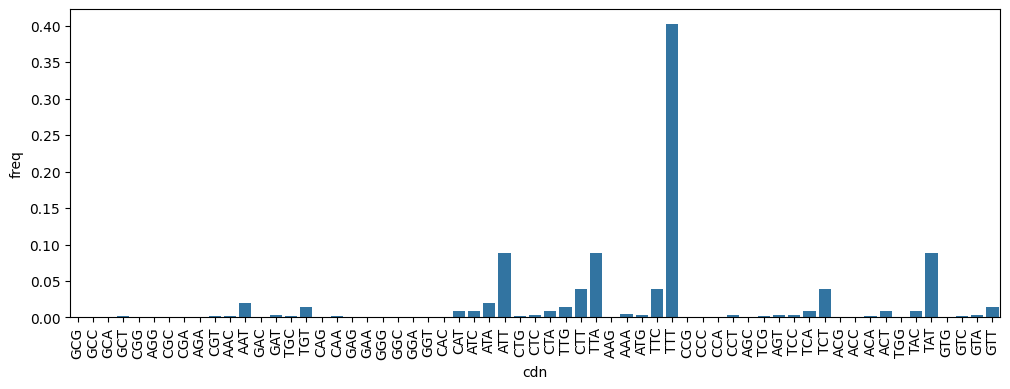

In [12]:
plt.figure(figsize=(12, 4))
sns.barplot(data=eq_freqs_cdn.sort_values(['aa', 'freq']).iloc[3:], 
            y='freq', x='cdn', )
plt.xticks(rotation=90);

In [13]:
eq_freqs_aa = eq_freqs_cdn[eq_freqs_cdn.aa !='*'].groupby('aa')['freq'].sum()
eq_freqs_aa /= eq_freqs_aa.sum()
eq_freqs_aa = eq_freqs_aa.sort_values(ascending=False).reset_index()
eq_freqs_aa.to_csv('./data/aa_eq_freqs.csv', index=False)
eq_freqs_aa.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
aa,Phe,Leu,Ile,Tyr,Ser,Asn,Val,Cys,Thr,His,Pro,Lys,Asp,Met,Arg,Gln,Ala,Glu,Gly,Trp
freq,0.453163,0.160812,0.119522,0.099586,0.058378,0.021885,0.020914,0.016945,0.012011,0.009731,0.005341,0.005127,0.003724,0.003392,0.002916,0.00228,0.002044,0.000872,0.000782,0.000577


## Load OBS

In [14]:
# https://media.githubusercontent.com/media/jbloomlab/SARS2-mut-spectrum/refs/heads/main/results/mutation_counts/aggregated.csv
obs_raw = pd.read_csv('data/aggregated.csv').query('subset == "all" & exclude == False')
obs = obs_raw[(obs_raw['synonymous'] == False)]

def _same_aa_mut(aa_mutation: str):
    variants = aa_mutation.split(';')
    return variants.count(variants[0]) == len(variants)
obs = obs[obs.aa_mutation.apply(_same_aa_mut)]
obs['aa1'] = obs['aa_mutation'].str[0]
obs['aa2'] = obs['aa_mutation'].str[-1]
# # obs['Mut'] = obs['mut_type'].str.replace('to', '>')
# same as in the paper table
# obs[obs.four_fold_degenerate].groupby('clade')['count'].sum().sort_index()
obs

,protein,aa_mutation,nt_mutation,codon_change,synonymous,count,nt_site,reference_nt,clade_founder_nt,exclude,exclude_reason,clade,subset,codon_position,four_fold_degenerate,aa1,aa2
0,ORF1ab,P5401L,C16466T,CCA>CTA,False,62,16466,C,C,False,NaN,19A,all,2,False,P,L
1,M,I82T,T26767C,ATC>ACC,False,54,26767,T,T,False,NaN,19A,all,2,False,I,T
3,ORF1ab,A6319V,C19220T,GCT>GTT,False,46,19220,C,C,False,NaN,19A,all,2,False,A,V
4,ORF1ab,I5658V,A17236G,ATA>GTA,False,45,17236,A,A,False,NaN,19A,all,1,False,I,V
5,ORF1ab,P4715L,C14408T,CCT>CTT,False,45,14408,C,C,False,NaN,19A,all,2,False,P,L
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979828,ORF1a;ORF1ab,T2756A;T2756A,A8531G,ACA>GCA;ACA>GCA,False,1,8531,A,A,False,NaN,22C,all,1,False,T,A
979829,ORF1a;ORF1ab,T2777A;T2777A,A8594G,ACA>GCA;ACA>GCA,False,1,8594,A,A,False,NaN,22C,all,1,False,T,A
979832,ORF1a;ORF1ab,T2825N;T2825N,C8739A,ACT>AAT;ACT>AAT,False,1,8739,C,C,False,NaN,22C,all,2,False,T,N
979833,ORF1a;ORF1ab,T2836A;T2836A,A8771G,ACA>GCA;ACA>GCA,False,1,8771,A,A,False,NaN,22C,all,1,False,T,A


In [15]:
obs_raw['count'].sum(), obs['count'].sum()

(np.int64(4132247), np.int64(2412204))

In [16]:
print('Number of mutations:')
obs_raw.groupby(['clade', 'synonymous'])['count'].sum().unstack()

Number of mutations:


synonymous,False,True
clade,,
19A,6576,3719
20A,58961,39770
20B,47332,32000
20C,31891,21898
20E,35238,24037
20F,2202,1311
20G,45508,33280
20I,207215,143847
20J,13188,9550


In [17]:
print('Number of mutations:')
obs_raw.query('synonymous == True').groupby(['clade', 'four_fold_degenerate'])['count'].sum().unstack()

Number of mutations:


four_fold_degenerate,False,True
clade,,
19A,2118,1601
20A,22568,17202
20B,17879,14121
20C,12554,9344
20E,13583,10454
20F,761,550
20G,19261,14019
20I,82989,60858
20J,5314,4236


In [18]:
obs.groupby('clade')['count'].sum().rename('aa_subst_cnt').sort_index().reset_index()

,clade,aa_subst_cnt
0,19A,6576
1,20A,58957
2,20B,47324
3,20C,31885
4,20E,35227
5,20F,2199
6,20G,45501
7,20I,207190
8,20J,13186
9,21C,20980


### Check site specifity

In [19]:
ref_sites_df = read_genbank_ref('data/NC_045512.2.gb')
ref_sites_df = ref_sites_df[ref_sites_df.Codon.notna()]
# Pos and nt_site is the same
ref_sites_df

/home/kpotoh/.pyenv/.venv_bio/lib64/python3.13/site-packages/Bio/SeqFeature.py:230: BiopythonDeprecationWarning: Please use .location.strand rather than .strand
  warnings.warn(
/home/kpotoh/.pyenv/.venv_bio/lib64/python3.13/site-packages/Bio/SeqFeature.py:230: BiopythonDeprecationWarning: Please use .location.strand rather than .strand
  warnings.warn(


,Pos,Nuc,Context,Strand,Type,gene,PosInGene,PosInCodon,Codon
265,266,A,GAT,1,mat_peptide,ORF1ab,1,1,ATG
266,267,T,ATG,1,mat_peptide,ORF1ab,2,2,ATG
267,268,G,TGG,1,mat_peptide,ORF1ab,3,3,ATG
268,269,G,GGA,1,mat_peptide,ORF1ab,4,1,GAG
269,270,A,GAG,1,mat_peptide,ORF1ab,5,2,GAG
...,...,...,...,...,...,...,...,...,...
29669,29670,C,ACA,1,CDS,ORF10,113,2,ACA
29670,29671,A,CAT,1,CDS,ORF10,114,3,ACA
29671,29672,T,ATA,1,CDS,ORF10,115,1,TAG
29672,29673,A,TAG,1,CDS,ORF10,116,2,TAG


In [20]:
ref_sites_df['MutCount'] = ref_sites_df['Pos'].map(obs.groupby('nt_site')['count'].sum()).fillna(0.)
ref_sites_df = ref_sites_df.merge(obs[['nt_site', 'codon_position']].drop_duplicates(), 
                   left_on='Pos', right_on='nt_site', how='left')
ref_sites_df

,Pos,Nuc,Context,Strand,Type,gene,PosInGene,PosInCodon,Codon,MutCount,nt_site,codon_position
0,266,A,GAT,1,mat_peptide,ORF1ab,1,1,ATG,0.0,NaN,NaN
1,267,T,ATG,1,mat_peptide,ORF1ab,2,2,ATG,1.0,267.0,2
2,268,G,TGG,1,mat_peptide,ORF1ab,3,3,ATG,0.0,NaN,NaN
3,269,G,GGA,1,mat_peptide,ORF1ab,4,1,GAG,149.0,269.0,1
4,270,A,GAG,1,mat_peptide,ORF1ab,5,2,GAG,111.0,270.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
29255,29670,C,ACA,1,CDS,ORF10,113,2,ACA,515.0,29670.0,2
29256,29671,A,CAT,1,CDS,ORF10,114,3,ACA,1.0,29671.0,3
29257,29672,T,ATA,1,CDS,ORF10,115,1,TAG,0.0,NaN,NaN
29258,29673,A,TAG,1,CDS,ORF10,116,2,TAG,0.0,NaN,NaN


In [21]:
ref_sites_df.MutCount.describe()

count    29260.000000
mean        82.440328
std        211.040767
min          0.000000
25%          1.000000
50%         16.000000
75%         68.000000
max       6323.000000
Name: MutCount, dtype: float64

In [22]:
ref_sites_df.MutCount.value_counts(normalize=True).rename('freq').reset_index()

,MutCount,freq
0,0.0,0.226384
1,1.0,0.051504
2,2.0,0.035954
3,3.0,0.026487
4,4.0,0.023377
...,...,...
1171,1261.0,0.000034
1172,1249.0,0.000034
1173,1117.0,0.000034
1174,1655.0,0.000034


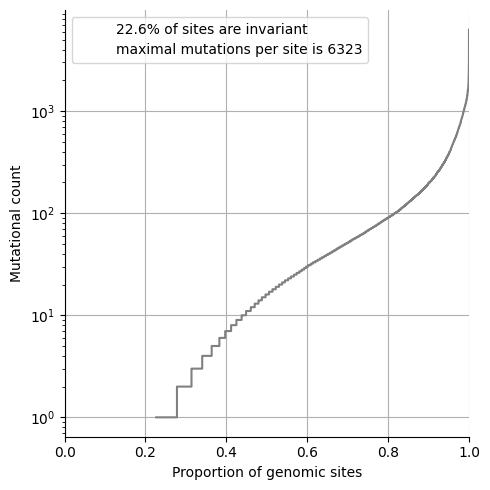

In [23]:
import matplotlib.patches as mpatches

sns.displot(ref_sites_df, y='MutCount', kind='ecdf', log_scale=(False, True), color='gray')
plt.legend([
        mpatches.Patch(color='none'), 
        mpatches.Patch(color='none'),
    ],[
        '22.6% of sites are invariant', 'maximal mutations per site is 6323'], 
    loc='upper left')
plt.grid(True)
plt.ylabel('Mutational count')
plt.xlabel('Proportion of genomic sites')
plt.tight_layout()
# plt.savefig('./figures/mutational_count_per_site_ecdf.pdf', dpi=300)
plt.show()

### compare obs and exp in table

In [24]:
grantham = pd.read_csv('../grantham.tsv', sep='\t', index_col=0).replace(0, np.nan)
grantham.index.name = 'aa1'
grantham_long = grantham.melt(ignore_index=False, var_name='aa2', value_name='granthamD').dropna().reset_index()
grantham_long['aa1'] = grantham_long['aa1'].map(amino_acid_codes)
grantham_long['aa2'] = grantham_long['aa2'].map(amino_acid_codes)
grantham_long = pd.concat([grantham_long, grantham_long.rename(columns={'aa1':'aa2', 'aa2':'aa1'})], ignore_index=True)
grantham_long

,aa1,aa2,granthamD
0,Ser,Arg,110.0
1,Ser,Leu,145.0
2,Arg,Leu,102.0
3,Ser,Pro,74.0
4,Arg,Pro,103.0
...,...,...,...
375,Trp,Asn,174.0
376,Trp,Lys,110.0
377,Trp,Asp,181.0
378,Trp,Glu,152.0


In [25]:
obs_clade = obs[obs['clade'] == '20A']
aa_subst = prepare_aa_subst(obs_clade, exp_aa_subst, aa_freqs_total_dct)
aa_subst['label'] = aa_subst.aa1 + '>' + aa_subst.aa2
aa_subst['mape'] = aa_subst['mape'].replace(-np.inf, 0)
aa_subst['diff_freqs_abs'] = (aa_subst['nobs_freqs'] - aa_subst['nexp_freqs']).abs()
aa_subst['division'] = (aa_subst['nobs_freqs'] / aa_subst['nexp_freqs'])
aa_subst['dist_to_diagonal'] = aa_subst['diff_freqs_abs'] / (2**0.5)
aa_subst = aa_subst.merge(grantham_long, 'left')
aa_subst.sort_values('mape')

,aa1,aa2,nobs,ref_aa1_freq,nobs_scaled,rate_exp,nexp,diff,mape,nobs_freqs,nexp_freqs,label,diff_freqs_abs,division,dist_to_diagonal,granthamD
57,Gly,Trp,50.0,0.059113,42.715580,0.324148,615.151637,-572.436057,-13.401107,0.000732,0.010535,Gly>Trp,0.009804,0.069439,0.006932,184.0
18,Arg,Trp,43.0,0.035920,60.455971,0.423543,803.779424,-743.323453,-12.295286,0.001035,0.013766,Arg>Trp,0.012730,0.075215,0.009002,101.0
12,Arg,Leu,247.0,0.035920,347.270343,1.296591,2460.606550,-2113.336207,-6.085565,0.005947,0.042141,Arg>Leu,0.036193,0.141132,0.025593,102.0
14,Arg,Met,81.0,0.035920,113.882177,0.324148,615.151637,-501.269460,-4.401650,0.001950,0.010535,Arg>Met,0.008585,0.185129,0.006070,91.0
1,Ala,Glu,20.0,0.067529,14.956945,0.039035,74.078845,-59.121901,-3.952806,0.000256,0.001269,Ala>Glu,0.001013,0.201906,0.000716,107.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,Lys,Arg,914.0,0.057677,800.292352,0.088100,167.191230,633.101122,0.791087,0.013706,0.002863,Lys>Arg,0.010843,4.786689,0.007667,26.0
96,Met,Thr,162.0,0.021244,385.108811,0.040320,76.517920,308.590892,0.801308,0.006595,0.001310,Met>Thr,0.005285,5.032923,0.003737,81.0
103,Phe,Val,123.0,0.051314,121.052536,0.012261,23.267794,97.784743,0.807788,0.002073,0.000398,Phe>Val,0.001675,5.202579,0.001184,50.0
45,Glu,Ala,161.0,0.045361,179.243078,0.015582,29.571270,149.671809,0.835021,0.003070,0.000506,Glu>Ala,0.002563,6.061393,0.001813,107.0


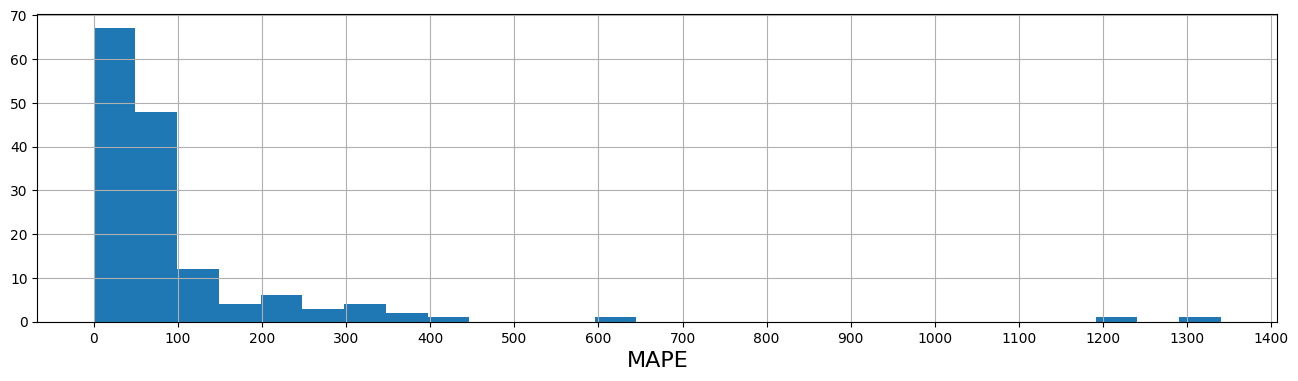

In [26]:
plt.figure(figsize=(16, 4))
(aa_subst.mape.abs()*100).hist(bins=27)
plt.xlabel('MAPE', fontsize=16)
plt.xticks(range(0, 1500, 100));

In [27]:
aa_subst.query('label == "Ser>Trp"')

,aa1,aa2,nobs,ref_aa1_freq,nobs_scaled,rate_exp,nexp,diff,mape,nobs_freqs,nexp_freqs,label,diff_freqs_abs,division,dist_to_diagonal,granthamD
121,Ser,Trp,0.0,0.0,0.0,0.007484,14.203554,-14.203554,0.0,0.0,0.000243,Ser>Trp,0.000243,0.0,0.000172,177.0


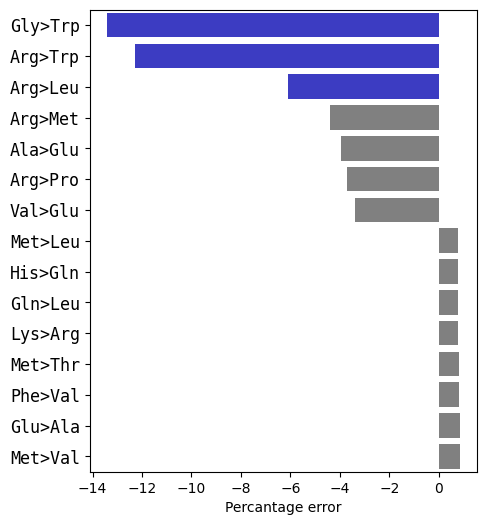

In [107]:
a = aa_subst['mape'][aa_subst['mape']>0].quantile(0.9)
b = aa_subst['mape'][aa_subst['mape']<0].quantile(0.1)

_d = aa_subst[(aa_subst['mape'] > a) | (aa_subst['mape'] < b)].copy()

plt.figure(figsize=(5, 6))
sns.barplot(aa_subst, y='label', x='mape', color='gray',
            order=_d.sort_values('mape').label)

# sns.barplot(aa_subst, y='label', x='mape', color='red', alpha=0.7,
#             order=_d.sort_values('mape').tail(3).label)
sns.barplot(aa_subst, y='label', x='mape', color='blue', alpha=0.7,
            order=_d.sort_values('mape').head(3).label)

plt.ylabel('')
# plt.xlim(-0.45, 0.45)
plt.xlabel('Percantage error')
plt.yticks(fontsize=12, fontname='monospace')
plt.show()

<Axes: >

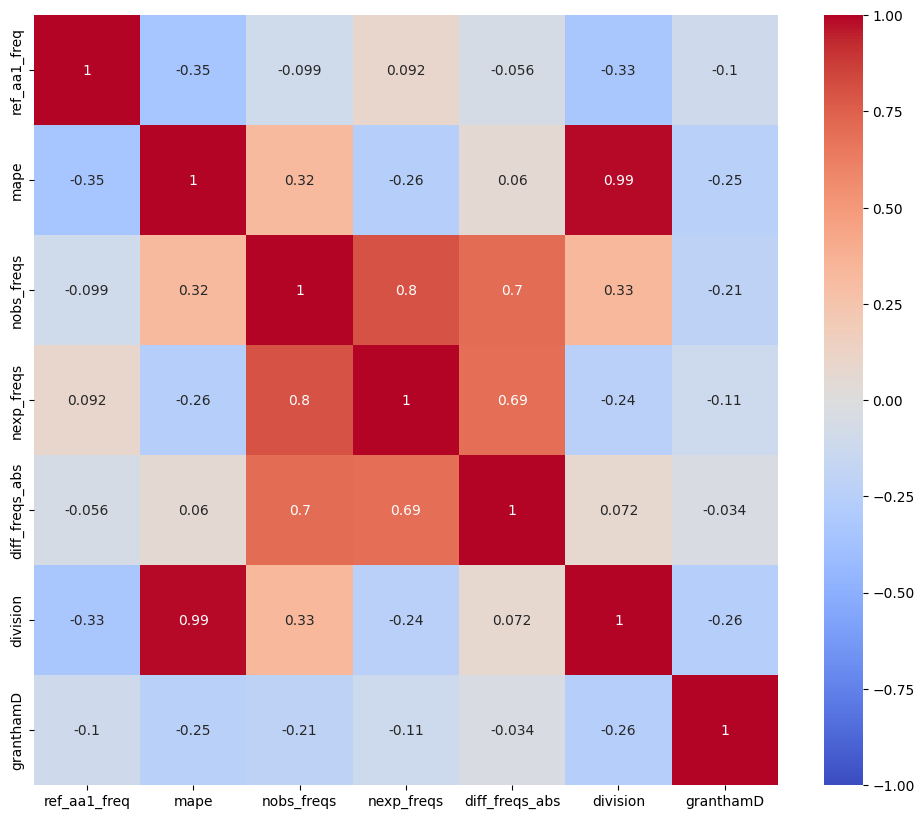

In [29]:
plt.figure(figsize=(12, 10))
sns.heatmap(aa_subst.drop(['aa1', 'aa2', 'label', 'nobs', 'nexp', 'nobs_scaled', 'dist_to_diagonal', 'diff', 'rate_exp'], axis=1).corr('spearman'), 
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)

Text(0, 0.5, 'Difference between OBS and PRED freqs')

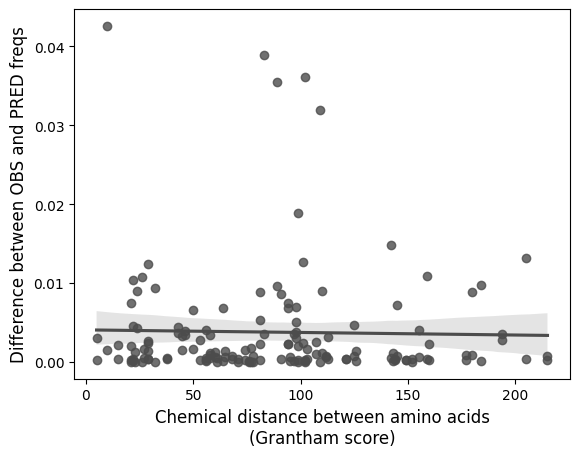

In [132]:
# plt.figure(figsize=(8, 8))
sns.regplot(aa_subst, x='granthamD', y='diff_freqs_abs', color='.3')
plt.xlabel('Chemical distance between amino acids\n(Grantham score)', fontsize=12)
plt.ylabel('Difference between OBS and PRED freqs', fontsize=12)
# plt.xscale('log')
# # plt.yscale('log')
# plt.text(2.5e-2, -3, '${MAPE=const}$', {'size': 16})
# plt.ylabel('MAPE')
# plt.xlabel('Observed frequency of amino acid substitution')

Text(0.5, 0, 'Observed frequency of amino acid substitution')

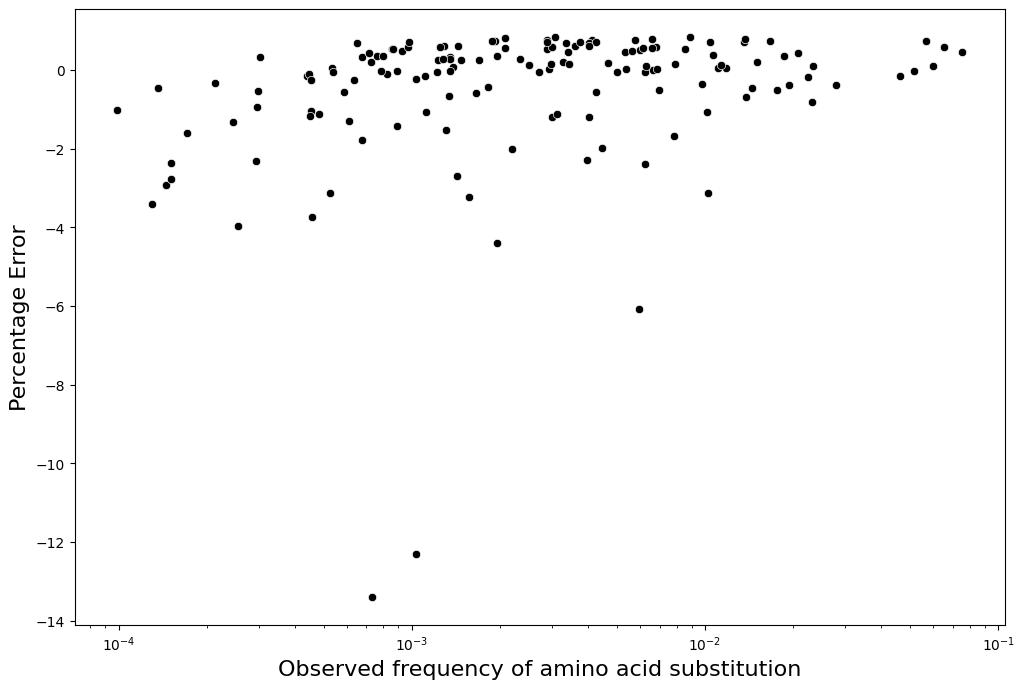

In [133]:
plt.figure(figsize=(12, 8))
sns.scatterplot(aa_subst, x='nobs_freqs', y='mape', c='k')
plt.xscale('log')
# plt.yscale('log')
# plt.text(2.5e-2, -3, '${MAPE=const}$', {'size': 16})
plt.ylabel('Percentage Error', fontsize=16)
plt.xlabel('Observed frequency of amino acid substitution', fontsize=16)

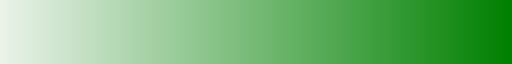

In [32]:
sns.color_palette("light:green", as_cmap=True)

In [38]:
def plot_exp_heatmap(exp_aa_subst_matrix: pd.DataFrame, save_path: str, show=True, annot=False):
    """
    Plot expected amino acid substitution matrix.
    """
    freqs_from = (exp_aa_subst_matrix.sum(1) - exp_aa_subst_matrix.values.diagonal()).copy()
    freqs_to = (exp_aa_subst_matrix.sum(0) - exp_aa_subst_matrix.values.diagonal()).copy()
    max_flow_value = max(freqs_to.max(), freqs_from.max())+0.1

    fig, axs = plt.subplots(2, 3, figsize=(11, 10), 
                            width_ratios=[0.1, 1, .05], height_ratios=[1, 0.1])
    sns.heatmap(exp_aa_subst_matrix, annot=annot, fmt=".2f", 
                ax=axs[0, 1], cbar_ax=axs[0, 2], 
                cmap=sns.color_palette("light:green", as_cmap=True), 
                cbar_kws={'label': 'Substitution rate'}, vmin=0,
                mask=exp_aa_subst_matrix==0,
    )
    axs[0, 1].set_ylabel('')
    axs[0, 1].set_xlabel('')
    axs[0, 1].set_xticks([])
    axs[0, 1].set_yticks([])
    # axs[0, 1].set_title('Expected substitution rates between amino acids')

    sns.barplot(freqs_from.reset_index(), y='aa1', x=0, ax=axs[0, 0],
                color='lightgray', edgecolor='black')
    axs[0, 0].set_ylabel('Original', fontsize=14)
    axs[0, 0].set_xlabel('Total Loss')
    axs[0, 0].spines['top'].set_visible(False)
    axs[0, 0].spines['right'].set_visible(False)
    axs[0, 0].spines['bottom'].set_visible(False)
    axs[0, 0].spines['left'].set_visible(False)
    axs[0, 0].invert_xaxis()
    axs[1, 1].set_ylim(0, max_flow_value)
    axs[0, 0].set_xticks([])
    axs[0, 0].set_yticklabels(axs[0, 0].get_yticklabels(), fontsize=12)

    sns.barplot(freqs_to.reset_index(), x='aa2', y=0, ax=axs[1, 1],
                color='lightgray', edgecolor='black')
    axs[1, 1].set_ylabel('Total Gain')
    axs[1, 1].set_xlabel('Mutant', fontsize=14)
    axs[1, 1].spines['top'].set_visible(False)
    axs[1, 1].spines['right'].set_visible(False)
    axs[1, 1].spines['bottom'].set_visible(False)
    axs[1, 1].spines['left'].set_visible(False)
    axs[1, 1].invert_yaxis()
    axs[1, 1].set_ylim(max_flow_value, 0)
    axs[1, 1].set_yticks([])
    axs[1, 1].set_xticklabels(axs[1, 1].get_xticklabels(), fontsize=12)

    axs[1, 0].remove()
    axs[1, 2].remove()

    plt.tight_layout()
    plt.savefig(save_path)
    if show:
        plt.show()
    else:
        plt.close(fig)

/tmp/ipykernel_501044/665892802.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0, 0].set_yticklabels(axs[0, 0].get_yticklabels(), fontsize=12)
/tmp/ipykernel_501044/665892802.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1, 1].set_xticklabels(axs[1, 1].get_xticklabels(), fontsize=12)


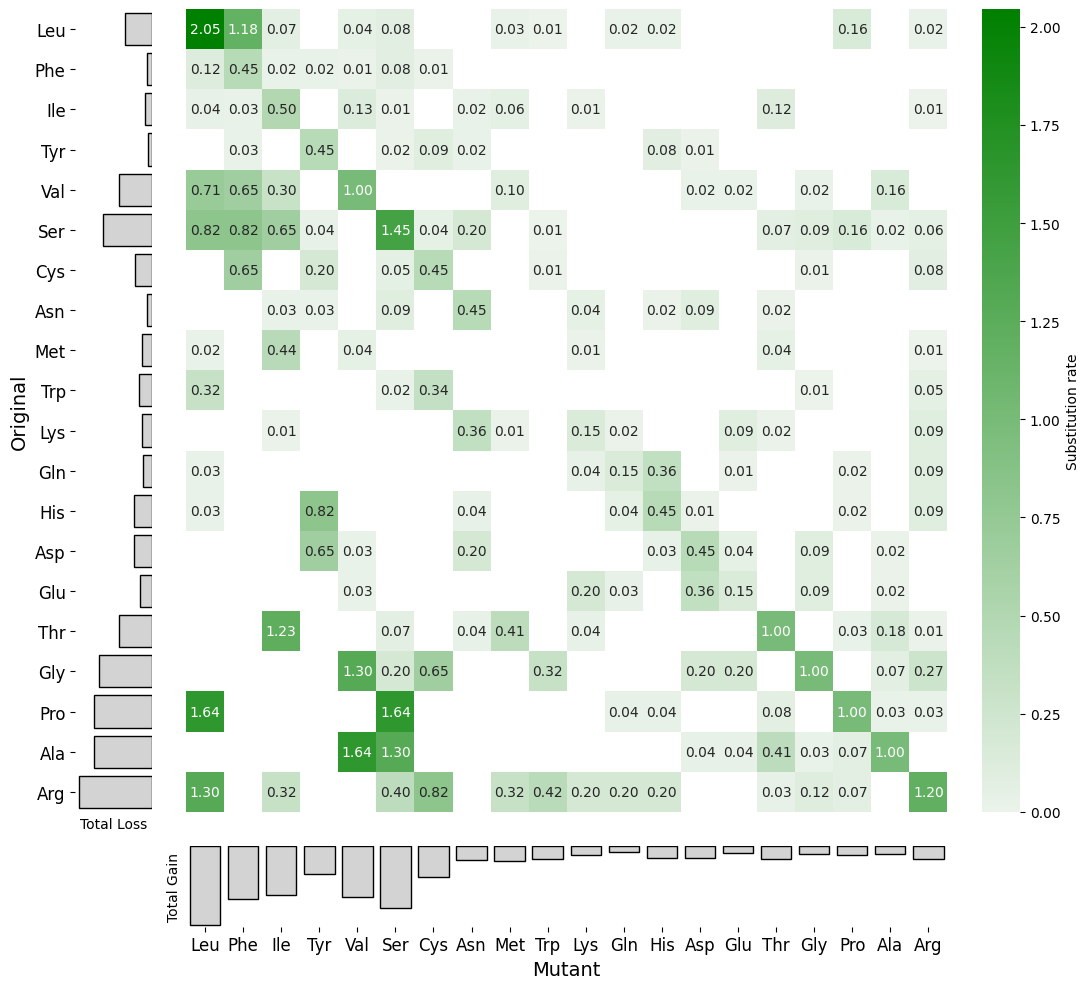

In [39]:
_, exp_aa_subst_matrix = prepare_exp_aa_subst(spectrum_20A, gc=1)

freqs_from = (exp_aa_subst_matrix.sum(1) - exp_aa_subst_matrix.values.diagonal()).copy()
freqs_to = (exp_aa_subst_matrix.sum(0) - exp_aa_subst_matrix.values.diagonal()).copy()

_freqs_to = (freqs_to / freqs_to.sum()).copy()
_freqs_from = (freqs_from / freqs_from.sum()).copy()
_freqs_to.index.name = 'aa'
_freqs_from.index.name = 'aa'

flow = (_freqs_to - _freqs_from).sort_values(ascending=False).rename('Flow').reset_index()

plot_exp_heatmap(exp_aa_subst_matrix.loc[flow.aa, flow.aa], 
                 'figures/exp_exp_aa_subst_matrix_20A.pdf', show=True, annot=True)

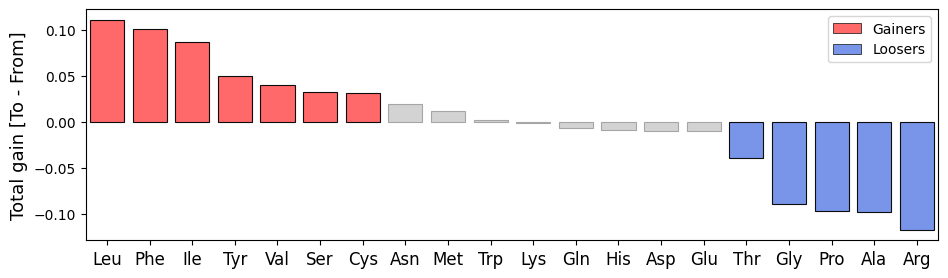

In [35]:
plt.figure(figsize=(11, 3))
ax = sns.barplot(
    flow, x='aa', y='Flow', color='lightgray', edgecolor=".65", linewidth=0.8)

cutoff = flow.Flow.abs().max() * 0.25

for bar in ax.patches:
    if bar.get_height() > cutoff:
        bar.set_color("#ff6969")
        bar.set_edgecolor('0.05')
    elif bar.get_height() < -cutoff:
        bar.set_color('#7995ea')
        bar.set_edgecolor('0.05')
        bar.set_linewidth


plt.legend([
    plt.Rectangle((0,0),1,1,fc="#ff6969", edgecolor='.05',linewidth=0.5), 
    plt.Rectangle((0,0),1,1,fc='#7995ea', edgecolor='.05',linewidth=0.5),
    ],['Gainers', 'Loosers',], loc='upper right')

# plt.title(f"{virusname}; G: {losers_gainers[i]['gainers']}; L: {losers_gainers[i]['losers']}")
plt.ylabel('Total gain [To - From]', fontsize=13)
plt.xlabel('')
plt.xticks(fontsize=12)
plt.show()

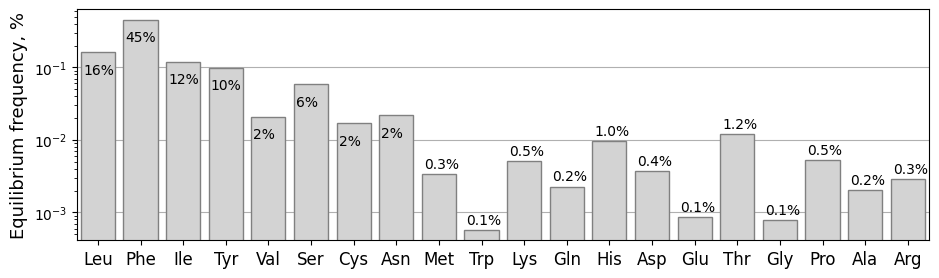

In [98]:
cur_eq_freqs_aa = pd.read_csv('./data/aa_eq_freqs.csv')

plt.figure(figsize=(11, 3))
ax=sns.barplot(cur_eq_freqs_aa, x='aa', y='freq', order=flow.aa, color='lightgray', edgecolor='gray')

for i, aa in enumerate(flow.aa.values):
    f = cur_eq_freqs_aa.query('aa == @aa').freq.item()
    x = i-0.35
    if f < 0.016:
        lbl = f"{f*100:.1f}%" 
        y = f * 1.2
    else:
        lbl = f"{f*100:.0f}%"
        y = f * 0.5
    ax.text(x, y, lbl)

plt.ylabel('Equilibrium frequency, %', fontsize=13)
plt.xticks(fontsize=12)
# plt.ylim(0, 1)
plt.xlabel('')
plt.yscale('log', base=10)
plt.grid(axis='y')
ax.set_axisbelow(True)
plt.show()

In [90]:
flow.head(7).aa

0    Leu
1    Phe
2    Ile
3    Tyr
4    Val
5    Ser
6    Cys
Name: aa, dtype: object

In [97]:
cur_eq_freqs_aa[cur_eq_freqs_aa.aa.isin(flow.head(7).aa)].freq.sum().round(2)

np.float64(0.93)

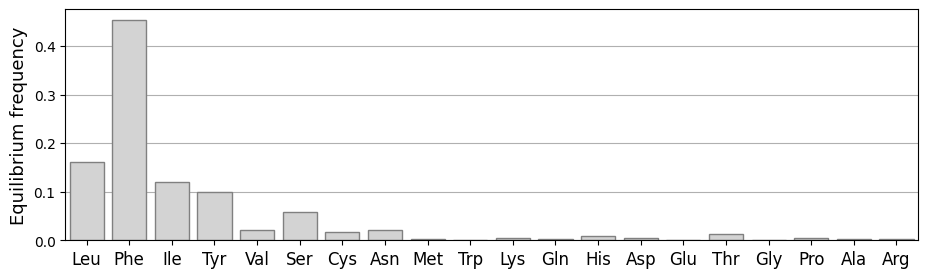

In [37]:
plt.figure(figsize=(11, 3))
ax=sns.barplot(cur_eq_freqs_aa, x='aa', y='freq', order=flow.aa, color='lightgray', edgecolor='gray')
plt.ylabel('Equilibrium frequency', fontsize=13)
plt.xticks(fontsize=12)
plt.xlabel('')
plt.grid(axis='y')
ax.set_axisbelow(True)
plt.show()

/home/kpotoh/.pyenv/.venv_bio/lib64/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Spearman correlation: 0.805 (p-value: 2.61e-35)


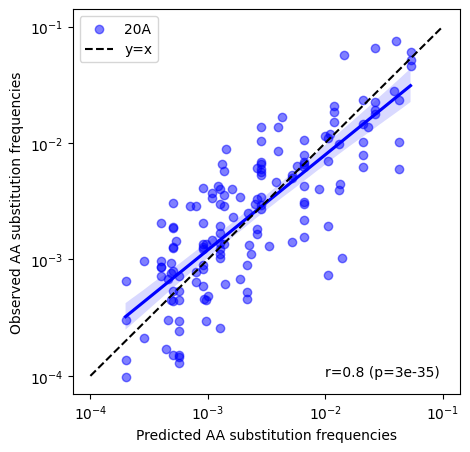

In [106]:
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, LogLocator

aa_subst['nobs_freqs_log'] = np.log10(aa_subst['nobs_freqs'])
aa_subst['nexp_freqs_log'] = np.log10(aa_subst['nexp_freqs'])

cor_res = spearmanr(aa_subst['nobs_freqs'], aa_subst['nexp_freqs'])
print(f"Spearman correlation: {cor_res.correlation:.3f} (p-value: {cor_res.pvalue:.3g})")

plt.figure(figsize=(5, 5))
ax = sns.regplot(aa_subst[aa_subst['nobs_freqs']>0], 
            color='blue', scatter_kws={'alpha':0.5},
            y='nobs_freqs_log', x='nexp_freqs_log', label='20A',)
# plt.scatter(aa_subst['nobs_freqs_log'], aa_subst['nexp_freqs_log'], 
#             c='green', s=30, alpha=0.5)
# plt.xscale('log')
# plt.yscale('log')

# ticks = np.log10(np.array([1e-4, 1e-3, 1e-2, 1e-1]))
ticks = np.linspace(-4, -1, 4)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
formatter = lambda x, pos: '10$^{' + str(int(x)) + '}$'
ax.get_xaxis().set_major_formatter(formatter)
ax.get_yaxis().set_major_formatter(formatter)
# ax.get_xaxis().set_minor_locator(LogLocator(-10, 'auto'))

plt.text(-2, -4., 
         f"r={cor_res.correlation:.1f} (p={cor_res.pvalue:.1g})", 
         fontsize=10)
plt.plot([-4, -1], [-4, -1], color='black', linestyle='--', label='y=x')
plt.ylabel('Observed AA substitution frequencies')
plt.xlabel('Predicted AA substitution frequencies')
plt.legend()
plt.savefig('./figures/obs_exp_aa_freqs_20A.pdf')
plt.show()

## Clade specific analysis

In [134]:
metrics_total_df = pd.read_csv('data/clades_fit_metrics.csv')\
    .set_index(['clade', 'sites_sample', 'sample_cutoff'])
metrics_total_df

mape      wape     slope  intercept  \
clade sites_sample   sample_cutoff                                            
20A   total          10             0.975288  0.571044  0.700099   0.001999   
      most variable  10             4.369140  0.775348  0.600406   0.002664   
      least variable 10             1.397830  1.007080  0.506767   0.003288   
      random         10             1.045180  0.615714  0.631046   0.002460   
      most variable  20             2.302500  0.679335  0.687794   0.002081   
...                                      ...       ...       ...        ...   
22C   least variable 20             1.620540  1.005010  0.500824   0.003328   
      random         20             1.514450  0.543044  0.717020   0.001887   
      most variable  30             2.023200  0.589993  0.754081   0.001639   
      least variable 30             1.937950  0.977353  0.567679   0.002882   
      random         30             2.736120  0.529688  0.778024   0.001480   

                                    spearman_corr    spearman_p  pearson_corr  \
clade sites_sample   sample_cutoff                                              
20A   total          10                  0.804557  2.605530e-35      0.764714   
      most variable  10                  0.681881  7.578330e-22      0.639102   
      least variable 10                  0.529277  3.325480e-12      0.333871   
      random         10                  0.735527  8.341110e-27      0.721969   
      most variable  20                  0.722313  1.778810e-25      0.716404   
...                                           ...           ...           ...   
22C   least variable 20                  0.587551  2.709870e-15      0.315383   
      random         20                  0.750598  2.017850e-28      0.808545   
      most variable  30                  0.750679  1.976040e-28      0.805897   
      least variable 30                  0.594744  1.017930e-15      0.345518   
      random         30                  0.757834  3.069440e-29      0.843849   

                                       pearson_p   ks_stat      ks_p  \
clade sites_sample   sample_cutoff                                     
20A   total          10             4.814520e-30  0.140000  0.105738   
      most variable  10             1.360430e-18  0.260000  0.000073   
      least variable 10             2.975730e-05  0.226667  0.000863   
      random         10             1.921950e-25  0.140000  0.105738   
      most variable  20             6.605030e-25  0.166667  0.030839   
...                                          ...       ...       ...   
22C   least variable 20             8.454530e-05  0.173333  0.021903   
      random         20             6.640090e-36  0.106667  0.361727   
      most variable  30             1.651480e-35  0.133333  0.139062   
      least variable 30             1.488110e-05  0.180000  0.015344   
      random         30             7.492030e-42  0.093333  0.532187   

                                        rmse  log_likelihood  mut_count  
clade sites_sample   sample_cutoff                                       
20A   total          10             0.008080        -5.37518      58390  
      most variable  10             0.009824        -5.51842      28948  
      least variable 10             0.011145        -6.32584       1154  
      random         10             0.009060        -5.35266       5837  
      most variable  20             0.008604        -5.43457      37555  
...                                      ...             ...        ...  
22C   least variable 20             0.011424        -6.24342       2200  
      random         20             0.007650        -5.31528      10796  
      most variable  30             0.007403        -5.34162      37137  
      least variable 30             0.011138        -6.24078       3300  
      random         30             0.006721        -5.32974      17103  

[140 rows x 13 columns]

In [135]:
metrics_total_df.reset_index().query('sites_sample == "total"')\
    .set_index('clade')[['wape','slope', 'spearman_corr', 'mut_count']].round(2)

,wape,slope,spearman_corr,mut_count
clade,,,,
20A,0.57,0.70,0.80,58390
20B,0.59,0.71,0.79,46932
20C,0.56,0.71,0.79,31691
20E,0.54,0.72,0.79,34924
20G,0.57,0.71,0.79,45231
20I,0.55,0.71,0.77,205188
21C,0.55,0.72,0.79,20840
21I,0.57,0.70,0.79,80214
21J,0.56,0.70,0.80,965925


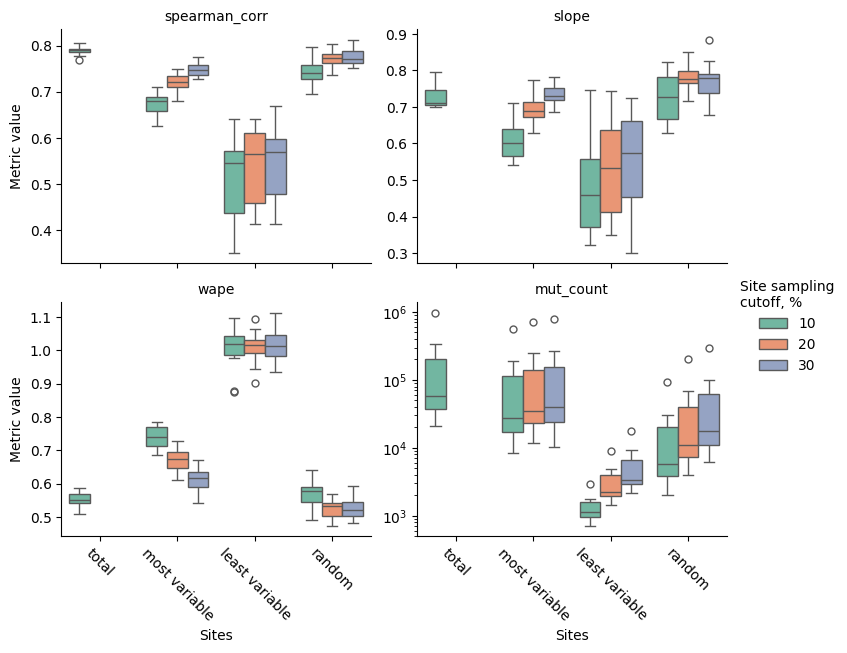

In [136]:
_ = metrics_total_df[['spearman_corr','slope', 'wape', 'mut_count']]\
    .melt(ignore_index=False, var_name='metric').reset_index()
g = sns.catplot(data=_, sharey=False, kind='box', col='metric', col_wrap=2,
                y='value', x='sites_sample', hue='sample_cutoff',  
                palette='Set2', height=3, aspect=1.25,
                # col_order=['accuracy']
)
g.set_titles('{col_name}')
g.set_xticklabels(g.axes[2].get_xticklabels(), rotation=-45)
g.set_xlabels('Sites')
g.set_ylabels('Metric value')
g.axes_dict['mut_count'].set_yscale('log')
g.legend.set_title('Site sampling\ncutoff, %')
g.savefig('./figures/clades_fit_metrics_boxplots.pdf')

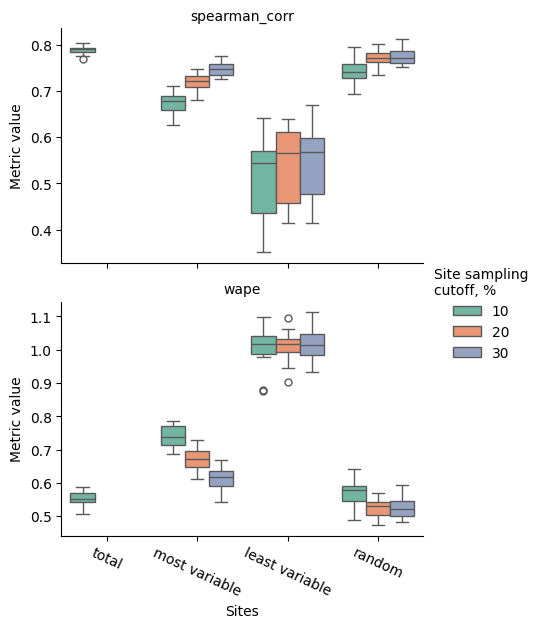

In [143]:
_ = metrics_total_df[['spearman_corr','wape']]\
    .melt(ignore_index=False, var_name='metric').reset_index()
g = sns.catplot(data=_, sharey=False, kind='box', col='metric', col_wrap=1,
                y='value', x='sites_sample', hue='sample_cutoff',  
                palette='Set2', height=3, aspect=1.5,
                # col_order=['accuracy']
)
g.set_titles('{col_name}')
g.set_xticklabels(g.axes[1].get_xticklabels(), rotation=-25)
g.set_xlabels('Sites')
g.set_ylabels('Metric value')
g.legend.set_title('Site sampling\ncutoff, %')
# g.savefig('./figures/clades_fit_metrics_boxplots.pdf')

In [13]:
metrics_total_df.sort_values('mut_count').tail(10)

mape      wape     slope  intercept  \
clade sites_sample  sample_cutoff                                           
20I   total         10             2.25137  0.549044  0.707446   0.001950   
21K   most variable 20             2.27568  0.610593  0.754368   0.001638   
21L   total         10             1.29903  0.525485  0.763998   0.001573   
21K   most variable 30             1.43163  0.542172  0.781266   0.001458   
21J   random        30             1.10653  0.544211  0.679339   0.002138   
21K   total         10             1.23298  0.507370  0.796750   0.001355   
21J   most variable 10             9.81788  0.709901  0.592760   0.002715   
                    20             2.31944  0.646454  0.662418   0.002251   
                    30             1.66754  0.585129  0.703745   0.001975   
      total         10             1.24926  0.560137  0.704800   0.001968   

                                   spearman_corr    spearman_p  pearson_corr  \
clade sites_sample  sample_cutoff                                              
20I   total         10                  0.769494  1.279860e-30      0.802529   
21K   most variable 20                  0.735476  8.441720e-27      0.796195   
21L   total         10                  0.777879  1.157870e-31      0.839276   
21K   most variable 30                  0.763308  7.066550e-30      0.834095   
21J   random        30                  0.812602  1.598240e-36      0.811591   
21K   total         10                  0.776622  1.671100e-31      0.856916   
21J   most variable 10                  0.700663  1.858920e-23      0.697109   
                    20                  0.746551  5.624560e-28      0.732066   
                    30                  0.770035  1.099680e-30      0.765873   
      total         10                  0.797127  3.064460e-34      0.771425   

                                      pearson_p   ks_stat      ks_p      rmse  \
clade sites_sample  sample_cutoff                                               
20I   total         10             5.158430e-35  0.080000  0.724957  0.007755   
21K   most variable 20             4.144170e-34  0.140000  0.105738  0.007418   
21L   total         10             5.305810e-41  0.100000  0.442524  0.006834   
21K   most variable 30             4.532540e-40  0.113333  0.291074  0.006750   
21J   random        30             2.286850e-36  0.086667  0.627917  0.007351   
21K   total         10             1.934160e-44  0.093333  0.532187  0.006309   
21J   most variable 10             3.832280e-23  0.233333  0.000541  0.009072   
                    20             1.892000e-26  0.146667  0.079310  0.008173   
                    30             3.502340e-30  0.106667  0.361727  0.007569   
      total         10             7.427420e-31  0.086667  0.627917  0.007509   

                                   log_likelihood  mut_count  
clade sites_sample  sample_cutoff                             
20I   total         10                   -5.29562     205188  
21K   most variable 20                   -5.38719     245406  
21L   total         10                   -5.34046     245921  
21K   most variable 30                   -5.35218     267915  
21J   random        30                   -5.28576     295969  
21K   total         10                   -5.35436     341745  
21J   most variable 10                   -5.32417     562350  
                    20                   -5.36775     716282  
                    30                   -5.37022     795119  
      total         10                   -5.40139     965925

## Random model on clades 

In [14]:
metrics_rnd_df = pd.read_csv('data/rnd_fit_metrics.csv', index_col=[0,1,2])
metrics_rnd_df

mape      wape     slope  intercept  spearman_corr  \
model   clade replica                                                           
neutral 20A   1        0.975288  0.571044  0.700099   0.001999       0.804557   
random  20A   1        5.217010  1.187420  0.026060   0.006493       0.178301   
              2        5.733470  1.175590 -0.048466   0.006990      -0.028007   
              3        4.728070  0.997108  0.154943   0.005634       0.267493   
              4        5.951160  1.141720 -0.012021   0.006747       0.026427   
...                         ...       ...       ...        ...            ...   
        22C   16       6.884280  1.184610 -0.048628   0.006991      -0.042651   
              17       8.311830  1.410040 -0.096533   0.007310      -0.203375   
              18       4.998610  0.979069  0.041713   0.006389       0.438899   
              19       8.581910  1.251160 -0.033828   0.006892      -0.131035   
              20       6.233050  1.177870  0.126954   0.005820       0.014194   

                         spearman_p  pearson_corr     pearson_p   ks_stat  \
model   clade replica                                                       
neutral 20A   1        2.605530e-35      0.764714  4.814520e-30  0.140000   
random  20A   1        2.903700e-02      0.049567  5.469350e-01  0.213333   
              2        7.337000e-01     -0.120579  1.416160e-01  0.380000   
              3        9.355830e-04      0.344713  1.562510e-05  0.313333   
              4        7.482040e-01     -0.031022  7.062860e-01  0.353333   
...                             ...           ...           ...       ...   
        22C   16       6.043000e-01     -0.132639  1.056500e-01  0.380000   
              17       1.255570e-02     -0.197521  1.540080e-02  0.273333   
              18       1.930170e-08      0.138842  9.017940e-02  0.446667   
              19       1.099720e-01     -0.085779  2.966190e-01  0.306667   
              20       8.631300e-01      0.266971  9.582310e-04  0.240000   

                               ks_p      rmse  log_likelihood  mut_count  
model   clade replica                                                     
neutral 20A   1        1.057380e-01  0.008080        -5.37518      58390  
random  20A   1        2.105860e-03  0.013510        -6.22005      58390  
              2        4.868720e-10  0.013697        -6.61325      58390  
              3        6.587400e-07  0.011532        -5.87733      58390  
              4        1.044100e-08  0.013230        -6.24762      58390  
...                             ...       ...             ...        ...  
        22C   16       4.868720e-10  0.014138        -6.42293      55848  
              17       2.445510e-05  0.015244        -6.90771      55848  
              18       7.609670e-14  0.012782        -5.96725      55848  
              19       1.247810e-06  0.014089        -6.43943      55848  
              20       3.347340e-04  0.012561        -6.22208      55848  

[294 rows x 13 columns]

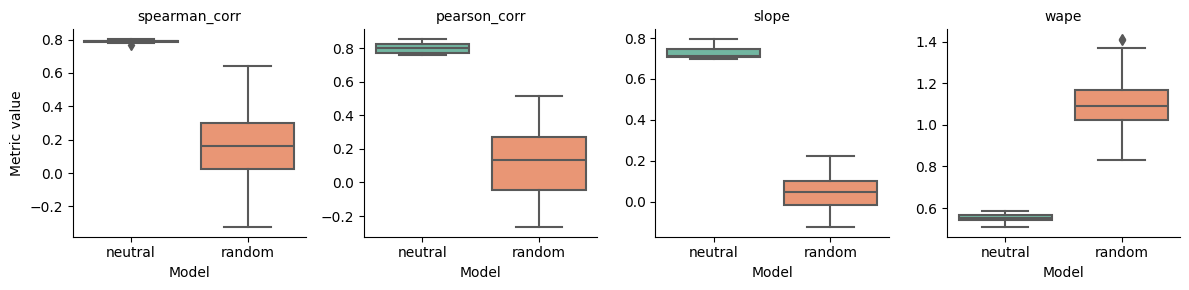

In [ ]:
_ = metrics_rnd_df[['spearman_corr', 'pearson_corr', 'slope', 'wape']]\
    .melt(ignore_index=False, var_name='metric').reset_index()
g = sns.catplot(data=_, sharey=False, kind='box', col='metric', 
                y='value', x='model', palette='Set2', height=3, aspect=1,
)
g.set_titles('{col_name}')
# g.set_xticklabels(g.axes[2].get_xticklabels(), rotation=-45)
g.set_xlabels('Model')
g.set_ylabels('Metric value')
g.savefig('./figures/rnd_fit_metrics_boxplots.pdf')
